# 18.8 - Regression Challenge

In [138]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import datetime

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()



In [139]:
house.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [193]:
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import matplotlib.pyplot as plt

def display_results(test, pred):
    plt.scatter(test, pred)
    plt.xlabel('Actual')
    plt.ylabel('Prediction')
    plt.plot(test, test, color="red")
    plt.show()

    print('R-Squared: \t\t\t{}'.format(round(r2_score(test, pred),4)))
    print('Mean Absolute Error: \t\t{}'.format(round(mean_absolute_error(test, pred)),0))
    print('Mean Squared Error: \t\t{}'.format(round(mse(test, pred)),0))
    print('Root Mean Squared Error: \t{}'.format(round(rmse(test, pred)),0))
    print('Mean Absolute Percentage Error: {}%'.format(round(np.mean(np.abs((test-pred)/test)*100),2)))

In [141]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(house.drop(columns=['id','saleprice']), house['saleprice'], test_size = 0.2, random_state = 465)

X_train_1 = X_train[['grlivarea', 'totalbsmtsf', 'fullbath', 'halfbath', 'overallqual', 'overallcond', 'yearbuilt', 'garagearea']]
X_train_1 = sm.add_constant(X_train_1)

results = sm.OLS(y_train, X_train_1).fit()

X_test_1 = X_test[['grlivarea', 'totalbsmtsf', 'fullbath', 'halfbath', 'overallqual', 'overallcond', 'yearbuilt', 'garagearea']]
X_test_1 = sm.add_constant(X_test_1)
y_pred_1 = results.predict(X_test_1)

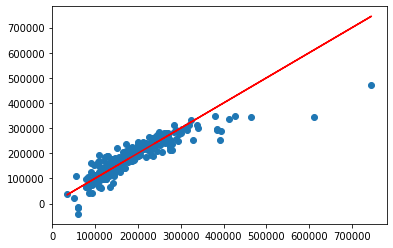

R-Squared: 			0.7829
Mean Absolute Error: 		24169.0
Mean Squared Error: 		1457655931.0
Root Mean Squared Error: 	38179.0
Mean Absolute Percentage Error: 14.83%


In [142]:
display_results(y_test, y_pred_1)

We have a lot of numeric variables that aren't being used. Let's try using a regularized model that selects from all our numeric variables.

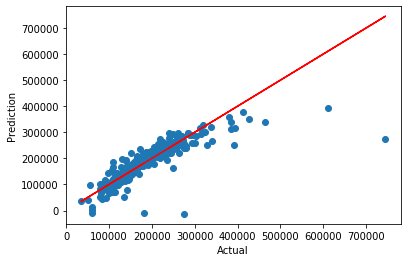

R-Squared: 			0.6832
Mean Absolute Error: 		23987.0
Mean Squared Error: 		2126685704.0
Root Mean Squared Error: 	46116.0
Mean Absolute Percentage Error: 13.57%


In [194]:
alphas=[10 ** i for i in range(-10,40)]
numerics = list((X_train.dtypes == 'int64') | (X_train.dtypes == 'float64'))

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)

X_train_2 = X_train.iloc[:,numerics]
X_train_2 = sm.add_constant(X_train_2)

lasso = LassoCV(alphas=alphas)
lasso = lasso.fit(X_train_2, y_train)

X_test_2 = X_test.iloc[:,numerics]
X_test_2 = sm.add_constant(X_test_2)
y_pred_2 = lasso.predict(X_test_2)

display_results(y_test, y_pred_2)

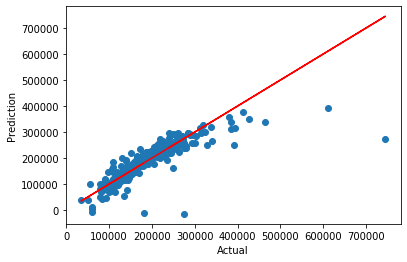

R-Squared: 			0.6824
Mean Absolute Error: 		23934.0
Mean Squared Error: 		2132381654.0
Root Mean Squared Error: 	46178.0
Mean Absolute Percentage Error: 13.53%


In [201]:
ridge = RidgeCV(alphas=alphas)
ridge = ridge.fit(X_train_2, y_train)
y_pred_3 = ridge.predict(X_test_2)

display_results(y_test, y_pred_3)

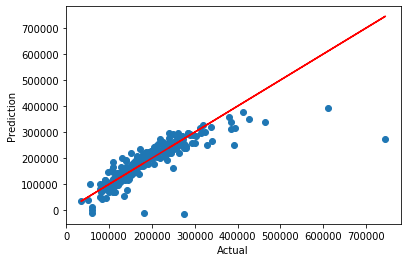

R-Squared: 			0.6827
Mean Absolute Error: 		23957.0
Mean Squared Error: 		2130120090.0
Root Mean Squared Error: 	46153.0
Mean Absolute Percentage Error: 13.55%


In [205]:
elastic = ElasticNetCV(alphas=alphas)
elastic = elastic.fit(X_train_2, y_train)
y_pred_4 = elastic.predict(X_test_2)

display_results(y_test, y_pred_4)

For all 3 of our regularized models, the r-squared and RMSE is significantly worse than our linear regression model (with only 8 independent variables), but our MAPE is significantly better. It may be the case that our regularized models do better with observations in our main "cluster," but does significantly worse for our outlier values.

I imported the Case-Shiller Housing Index to account for price fluctuations from the housing market more generally. Given a set of factors, a house will sell for more or less than usual if the housing market is up or down.

In [206]:
case_shiller = pd.read_csv('CSUSHPINSA.csv', header=0)
case_shiller.DATE[1]

case_shiller['DATE'] = case_shiller['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
case_shiller['year'] = case_shiller['DATE'].apply(lambda x: x.year)
case_shiller['month'] = case_shiller['DATE'].apply(lambda x: x.month)

house = pd.merge(house, case_shiller, left_on=['mosold','yrsold'], right_on=['month','year'], how='left')

X_train, X_test, y_train, y_test = train_test_split(house.drop(columns=['id','saleprice']), house['saleprice'], test_size = 0.2, random_state = 465)

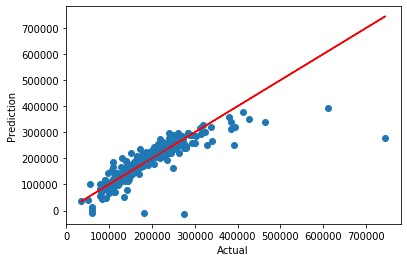

R-Squared: 			0.6837
Mean Absolute Error: 		23941.0
Mean Squared Error: 		2123504340.0
Root Mean Squared Error: 	46081.0
Mean Absolute Percentage Error: 13.54%


In [207]:
numerics = list((X_train.dtypes == 'int64') | (X_train.dtypes == 'float64'))

X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_train.mean(), inplace=True)

X_train_3 = X_train.iloc[:,numerics]
X_train_3 = sm.add_constant(X_train_3)

lasso = LassoCV(alphas=alphas)
lasso = lasso.fit(X_train_3, y_train)

X_test_3 = X_test.iloc[:,numerics]
X_test_3 = sm.add_constant(X_test_3)
y_pred_3 = lasso.predict(X_test_3)

display_results(y_test, y_pred_3)

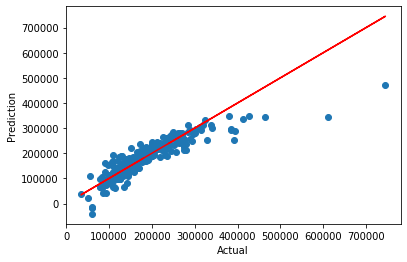

R-Squared: 			0.7829
Mean Absolute Error: 		24164.0
Mean Squared Error: 		1457445884.0
Root Mean Squared Error: 	38177.0
Mean Absolute Percentage Error: 14.83%


In [213]:
X_train_4 = X_train[['grlivarea', 'totalbsmtsf', 'fullbath', 'halfbath', 'overallqual', 'overallcond', 'yearbuilt', 'garagearea', 'CSUSHPINSA']]
X_train_4 = sm.add_constant(X_train_4)

results = sm.OLS(y_train, X_train_4).fit()

X_test_4 = X_test[['grlivarea', 'totalbsmtsf', 'fullbath', 'halfbath', 'overallqual', 'overallcond', 'yearbuilt', 'garagearea', 'CSUSHPINSA']]
X_test_4 = sm.add_constant(X_test_4)
y_pred_4 = results.predict(X_test_4)

display_results(y_test, y_pred_4)

Adding in the price index didn't increase our model's performance. Apparently a linear time trend works just as well.